Adapted from tutorials at pytorch.org

<h3> Pytorch updates </h3>

https://github.com/pytorch/pytorch/releases/tag/v0.4.0

# Defining a CNN with nn 

<h3> Defining LeNet network for example </h3>

<img src=http://pytorch.org/tutorials/_images/mnist.png>

https://www.youtube.com/watch?v=KiftWz544_8

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

<h3> Defining our network </h3>

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, self.num_flat_features(x))
#         x = x.view(-1, 16*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
net = Net()

In [6]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
net.parameters()

<generator object Module.parameters at 0x111e587d8>

In [8]:
for param in list(net.parameters()):
    print(param.size())

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


Let expected input image size to this net(LeNet) be 32x32. 

nSamples x nChannels x Height x Width

torch.nn only supports mini-batches

If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [20]:
# input = Variable(torch.randn(2, 1, 32, 32)) # Old pytorch
input = torch.randn(2, 1, 32, 32)

In [21]:
output = net(input)

In [22]:
output

tensor([[-0.0876,  0.0901,  0.0399,  0.0132, -0.0630,  0.0864, -0.1035,
         -0.0499,  0.1477,  0.0692],
        [-0.0742,  0.0808,  0.0630,  0.0338, -0.0879,  0.0528, -0.1042,
         -0.0312,  0.1423,  0.0703]])

In [25]:
_, predicted = torch.max(output.data, 1)

In [26]:
predicted

tensor([ 8,  8])

In [27]:
net(input)[0]

tensor([-0.0876,  0.0901,  0.0399,  0.0132, -0.0630,  0.0864, -0.1035,
        -0.0499,  0.1477,  0.0692])

<h3> Loss function </h3>

In [33]:
output = net(input)
target = torch.randn(2, 10)  # a dummy target, for example
target = target.view(2, -1)  # make it the same shape as output
loss_fn = nn.MSELoss()

loss = loss_fn(output, target)
print(loss)

tensor(1.1920)


Zero the gradient buffers of all parameters

In [30]:
net.zero_grad()  

In [31]:
print(net.conv1.bias.grad)

None


<h3> Backward pass </h3>

In [34]:
loss.backward()

In [35]:
print(net.conv1.bias.grad)

tensor(1.00000e-02 *
       [-0.3497,  2.3310, -1.5434,  1.6574, -0.4794,  0.3197])


<h3> Learning rule </h3>

weight = weight - learning_rate * gradient

learning_rate = 0.01

for f in net.parameters():

    f.data.sub_(f.grad.data * learning_rate)

In [36]:
import torch.optim as optim

In [37]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

<h3> Combining everything for training </h3>

In [38]:
# zero the gradient buffers
optimizer.zero_grad()   

# Forward pass 
output = net(input) 

# Loss calculation 
loss = loss_fn(output, target)

# Backward pass
loss.backward()

# Paramter update
optimizer.step()   

# Putting everything together for CIFAR

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [39]:
import torchvision

In [40]:
import torchvision.transforms as transforms

In [62]:
import numpy as np 

In [63]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [41]:
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=None)
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
len(trainset)

50000

In [53]:
len(testset)

10000

In [42]:
ind = 4

In [43]:
testset[ind]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x11DACCE10>, 6)

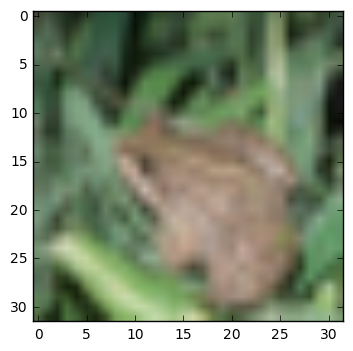

In [47]:
plt.imshow(testset[ind][0])

In [49]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [50]:
classes[testset[ind][1]]

'frog'

<h3> Normalize images </h3>

In [59]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    )

In [80]:
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


<h3> Make batches of images </h3>

In [81]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

In [82]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True)

In [83]:
it_train = iter(trainloader)

In [84]:
imgs, lbls = it_train.next()

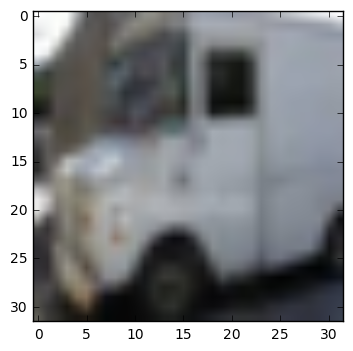

In [85]:
imshow(imgs[0])

In [86]:
classes[lbls[0]]

'truck'

In [87]:
imgs.shape

torch.Size([4, 3, 32, 32])

# We will use LeNet defined earlier

<h3> Loss function </h3>

In [76]:
criterion = nn.CrossEntropyLoss()

https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation

<h3> Learning rule </h3>

In [78]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

<h3> Train!! (In separate notebook) </h3>